<a href="https://colab.research.google.com/github/kareem1925/Ismailia-school-of-AI/blob/master/machine%20learning%20for%20classifying%20quantum%20states/Qiskit%20code%20for%20learning%20Q%20states.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/kareem1925/qiskit-aqua.git@kareem1925-mentor 

  Cloning https://github.com/kareem1925/qiskit-aqua.git (to revision kareem1925-mentor) to /tmp/pip-req-build-oyjmz51s
  Running command git clone -q https://github.com/kareem1925/qiskit-aqua.git /tmp/pip-req-build-oyjmz51s
  Running command git checkout -b kareem1925-mentor --track origin/kareem1925-mentor
  Switched to a new branch 'kareem1925-mentor'
  Branch 'kareem1925-mentor' set up to track remote branch 'kareem1925-mentor' from 'origin'.
     |████████████████████████████████| 2.9MB 2.8MB/s 
     |████████████████████████████████| 102kB 10.3MB/s 
     |████████████████████████████████| 5.6MB 23.8MB/s 
     |████████████████████████████████| 573kB 45.0MB/s 
     |████████████████████████████████| 24.3MB 91kB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 51kB 9.3MB/s 
  Created wheel for qiskit-aqua: filename=qiskit_aqua-0.7.0-cp36-none-any.whl size=1740668 sha256=24839c16dcfe3e254ef606705506ac1fb18ea001131543d6cc150cf2b269de3e
 

In [2]:
!pip install qiskit-aer qiskit-ignis qiskit-terra qiskit-ibmq-provider -q

     |████████████████████████████████| 23.1MB 130kB/s 
     |████████████████████████████████| 143kB 56.0MB/s 
     |████████████████████████████████| 153kB 61.2MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 2.3MB 53.6MB/s 


In [0]:
import numpy as np
from qiskit import *
from qiskit import Aer
from qiskit.aqua.components.optimizers import *
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info.analysis import average_data,hellinger_fidelity
from qiskit.providers.aer.noise import NoiseModel
from qiskit.aqua.utils import get_subsystem_density_matrix
from qiskit.tools.visualization import plot_histogram
import matplotlib.pyplot as plt

np.set_printoptions(precision=15)
%matplotlib inline

In [4]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright


In [5]:
IBMQ.save_account('6bc586c2edbc45d0779dfde326149f8a176a4f43dcf1e4d8e163050315f12b5ceef0b04bc1797e5929f684140abe79c5cb06209c93280a6d0272490f018eff2b', overwrite=True)
provider = IBMQ.load_account()
provider.backends()
device_backend = provider.get_backend('ibmq_vigo')
coupling_map = device_backend.configuration().coupling_map
noise_model = NoiseModel.from_backend(device_backend)
print(noise_model)
basis_gates = noise_model.basis_gates

# Select the QasmSimulator from the Aer provider
simulator = Aer.get_backend('qasm_simulator')

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['measure', 'id', 'u2', 'cx', 'u3']
  Qubits with noise: [0, 1, 2, 3, 4]
  Specific qubit errors: [('id', [0]), ('id', [1]), ('id', [2]), ('id', [3]), ('id', [4]), ('u2', [0]), ('u2', [1]), ('u2', [2]), ('u2', [3]), ('u2', [4]), ('u3', [0]), ('u3', [1]), ('u3', [2]), ('u3', [3]), ('u3', [4]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 2]), ('cx', [1, 3]), ('cx', [2, 1]), ('cx', [3, 1]), ('cx', [3, 4]), ('cx', [4, 3]), ('measure', [0]), ('measure', [1]), ('measure', [2]), ('measure', [3]), ('measure', [4])]


In [0]:
def circuit(params):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    qc = QuantumCircuit(q,c)
    #qc.h(q[0])
    
    qc.ry(params[0],q[0])
#    qc.rx(params[1],q[0])
    
    qc.cx(q[0],q[1])
    qc.snapshot('0')
    qc.measure(q[0],c[0])
    qc.measure(q[1],c[1])
    job = execute(qc, simulator, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates,shots=10,backend_options={"max_parallel_threads":10}).result()
    
    statevector = np.array(job.data()['snapshots']['statevector']['0'][0])
    statevector = get_subsystem_density_matrix(statevector,[2,3,4])
    counts = job.get_counts()
    return counts, statevector


In [0]:
def cross_entropy(pred, targets, epsilon=1e-20):

    pred = np.clip(pred, epsilon, 1. - epsilon)
    
    n_samples = pred.shape[0]
    
    loss = -np.sum(targets*np.log10(pred+epsilon))/n_samples

    return loss

labels = np.array([0.5,0,0,0.5])
labels_vector = np.array([1/np.sqrt(2),0,0,1/np.sqrt(2)])
c = {'01': 0, '11': 50, '00': 50, '10': 0}

def cost(var):
    

#    print(var)
    st_vec = circuit(var)[1]

#    return cross_entropy(circuit(var),la)
    
    res = abs(1 - state_fidelity(st_vec,labels_vector))
#    res = - hellinger_fidelity(c,st_vec)
#    print(hellinger_fidelity(c,st_vec))

    return res

In [34]:
np.random.seed(5)
init_params = np.random.randn(1)
#init_params = [1.57079633]
print(init_params)
print(cost(init_params))

[0.441227486885041]
0.28647514264932206


In [0]:
opt = AQGD(disp=True,maxiter=1000,tol=1e-16,eta=0.1)
#opt = ADAM(tol=1e-11,lr=0.05)

In [0]:
D = opt.optimize(objective_function=cost,num_vars=1,initial_point=init_params)

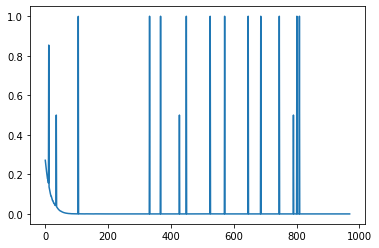

In [37]:
plt.plot(D[3])

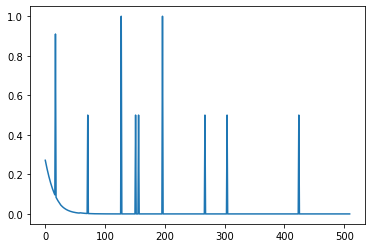

In [38]:
plt.plot(V[3])

In [39]:
np.argmin(D[3]),np.argmin(V[3])

(967, 493)

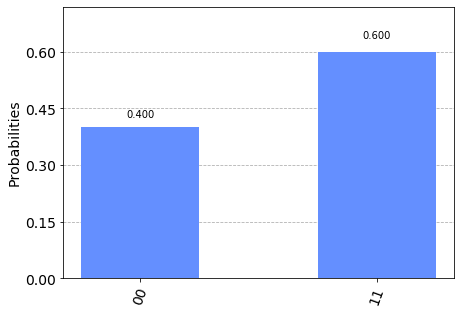

In [159]:
counts,density_matrix = circuit([1.570796873664514])
plot_histogram(counts)

In [160]:
print(state_fidelity(density_matrix,labels_vector))

0.9999999999999251
